In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import scipy as sp
from scipy import constants
from scipy import integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jplephem as jpl #jpl spk, open kernal , date -> days
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon, get_body_barycentric_posvel
from astropy import units as u
import astropy as ap
import allantools as at
from jplephem.spk import SPK
from scipy import constants
kernel = SPK.open('de430.bsp')

In [3]:
#CONSTANTS
G = constants.G
c = constants.speed_of_light
AU = 1.496e8 #km
JD = 3600*24 #s

#MASSES
M_sun = 1.99e30
M_merc = 3.30e23 
M_venus = 4.87e24
M_earth = 5.97e24
M_moon = 7.35e22
M_mars = 6.42e23
M_jup = 1.90e27
M_sat = 5.68e26
M_uran = 8.68e25
M_nept = 1.02e26
M_pluto = 1.31e22
ss_mass = [M_sun, M_merc, M_venus, M_earth, M_moon, M_mars, M_jup, M_sat, M_uran, M_nept, M_pluto] #solar system

#SEM system
SEM = ['sun','earth','moon']
sem_masses = [M_sun, M_earth, M_moon]

In [4]:
#JPL Model of the Solar System
solar_system_ephemeris.set('de430.bsp') #file path
#directory: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/
solar_bodies = list(solar_system_ephemeris.bodies) #list of bodies, tuple to list
solar_bodies.remove('earth-moon-barycenter') 
#solar_bodies SELF NOTE: SUN[0], EARTH[3], MOON[4]

In [5]:
#USEFUL FUNCTIONS
#1.Time Delay
def dtau (M,r,dt):
    """
    dt in JD (time period integrated over)
    r in AU (distance away from r, scalar)
    
    dtau = proper time at r due to M in s
    """
    dtau = (np.sqrt(1-((2*G*M)/(r*AU*((c)**2)))))*dt*JD
    return dtau

#3.Rotation (For LP estimations)
from math import pi ,sin, cos

def R(theta, u):
    return [[cos(theta) + u[0]**2 * (1-cos(theta)), 
             u[0] * u[1] * (1-cos(theta)) - u[2] * sin(theta), 
             u[0] * u[2] * (1 - cos(theta)) + u[1] * sin(theta)],
            [u[0] * u[1] * (1-cos(theta)) + u[2] * sin(theta),
             cos(theta) + u[1]**2 * (1-cos(theta)),
             u[1] * u[2] * (1 - cos(theta)) - u[0] * sin(theta)],
            [u[0] * u[2] * (1-cos(theta)) - u[1] * sin(theta),
             u[1] * u[2] * (1-cos(theta)) + u[0] * sin(theta),
             cos(theta) + u[2]**2 * (1-cos(theta))]]

def Rotate(VecToRotate, u, theta):
    n = u/np.linalg.norm(u)
    r = R(theta, n)
    rotated = np.matmul(r,VecToRotate)
    return rotated


In [6]:
#Initial ephem data extraction function
def Generate_Solar_Sys_Data(ti, t_total, dt=1, bodies=solar_bodies, plot=False, plotvel=False, d=2):
    """
    ti - Start time (isot)
    t_total - length of time in JD
    dt - time sample interval (t_total/dt = # time data)
    """
    n_b = len(bodies) #No. bodies
    ntdata = int(t_total/dt)
    
    #Create empty 2d arrays
    positions = np.empty([n_b, ntdata, 3]) #rows=bodies
    velocities = np.empty([n_b, ntdata])
    
    #Create time series
    allt = ti + t_total * np.linspace(0., 1., ntdata)
    print("end time =", allt[-1])
    
    for i in range(n_b):
        for j in range(ntdata):
            output = get_body_barycentric_posvel(bodies[i],allt[j]) #get position and velocity
            positions[i][j] = list((output[0].get_xyz().to_value())*6.68459e-9) #unit = AU
            velocities[i][j] = np.linalg.norm(output[1].get_xyz().to_value()) #magvel, unit = AU/day
   
    #L-Points Estimation
    possun = positions[0]
    posearth = positions[3]
    posmerc = positions[1]
    r_se = posearth - possun #sun-earth dist
    
    L1 = np.empty([ntdata,3])
    L2 = np.empty([ntdata,3])
    L3 = np.empty([ntdata,3])
    L4 = np.empty([ntdata,3])
    L5 = np.empty([ntdata,3])
    normal = np.cross(r_se[0],posmerc[0]-possun[0])
    for i in range(ntdata):
        L1[i] = (1-((M_earth/(M_sun + M_earth))**(1/3)))*r_se[i]
        L2[i] = (1+((M_earth/(M_sun + M_earth))**(1/3)))*r_se[i]
        L3[i] = (-1-((5*M_earth)/(12*(M_sun + M_earth))))*r_se[i]
        L4[i] = Rotate(posearth[i],normal,-pi/3)
        L5[i] = Rotate(posearth[i],normal,pi/3)
    
    L_points = np.stack((L1,L2,L3,L4,L5))
    
    #Plot the orbits
    if plot == True:
        #2D Trajectory
        if d == 2:
            plt.figure(figsize=(20,6))
            for i in range(n_b):
                x_singlebody = np.transpose(positions[i])
                plt.plot(x_singlebody[0],x_singlebody[1],'--',label=bodies[i])
            x_l1 = np.transpose(L1)
            x_l2 = np.transpose(L2)
            x_l3 = np.transpose(L3)
            x_l4 = np.transpose(L4)
            x_l5 = np.transpose(L5)
            plt.plot(x_l1[0],x_l1[1],label='L1')
            plt.plot(x_l2[0],x_l2[1],label='L2')
            plt.plot(x_l3[0],x_l3[1],label='L3')
            plt.plot(x_l4[0],x_l4[1],label='L4')
            plt.plot(x_l5[0],x_l5[1],label='L5')
            plt.legend()
            plt.title('Solar System Orbits')
            plt.show()
            
        #3D Trajectory
        if d == 3:
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(projection = '3d')
            for i in range (n_b):
                x_singlebody = np.transpose(positions[i])
                ax.plot3D(x_singlebody[0],x_singlebody[1],x_singlebody[2],label = bodies[i])
            plt.legend()
            plt.title('Solar System Orbits')
            plt.show()
            
    #Plot velocity
    if plotvel == True:
        plt.figure(figsize=(20,6))
        allt_jd = np.empty(len(allt))
        for nt in range(len(allt)):
            allt_jd[nt] = allt[nt].jd
        for i in range(n_b):
            v_singlebody = velocities[i]
            plt.plot(allt_jd,v_singlebody,'--',label=bodies[i])
        plt.legend()
        plt.title('Solar System Velocities')
        plt.ylabel('v (AU/day)')
        plt.xlabel('t (JD)')
        plt.show()
                  
    return positions, allt, velocities, L_points

In [7]:
class ClockNetwork:
    """
    This class contains all clock methods:
    - add clock to a position
    - calculate time dilation signal between two clocks
    - generate add noise to the signal
    N.B. Take the sun as the origion
    """
    def __init__(self, r, f0):
        """
        r - list of clock positions (L_points, moving)
        f0 - nominal freq (constant, assume all clocks have the same nominal frequency)
        """
        self.r = r #Positions 
        self.f0 = f0 #Nominal frequency (assumed constant for all clocks)
        self.n_c = len(self.r) # No. Clocks
        
    def add_clock (self, new_r):
        """
        new_r - position of the new clock
        """
        self.r.append(new_r)
        self.n_c = self.n_c + 1
    
    def calc_rel_dist (self, t, cindex, bodies, pos_bodies, plot=False):
        """
        t - time array
        cindex - index of the clock
        bodies - list of bodies 
        pos_bodies - position arrays for all solar system bodies
        """
        
        r_sun = pos_bodies[0] #position of the sun
        r_clock = self.r[cindex] #position of the clock
        
        #Calculate positions of all bodies relative to the sun
        relpos_bodies=[]
        for i in pos_bodies:
            relpos_bodies.append(r_sun - i)
    
        #Calculate positions of the clock relative to all the bodies
        relpos_clock = [] 
        for i in relpos_bodies:
            relpos_clock.append(r_clock - i)
            
        #Calculate the norm
        relpos_norm = np.empty([len(relpos_clock),(len(relpos_clock[0]))])
        
        for i in range(len(relpos_clock)):
            for j in range(len(relpos_clock[0])):
                relpos_norm[i][j] = np.linalg.norm(relpos_clock[i][j])
    
        #Plot clock positions relative to all bodies
        if plot == True:
            plt.figure(figsize=(20,6))
            for i in range(len(relpos_norm)):
                plt.plot(t.jd, relpos_norm[i], label=bodies[i])
            plt.xlabel('t [JD]')
            plt.ylabel('x [AU]')
            plt.legend()
            plt.title('Relative Distances')
            plt.show()
    
        return relpos_clock, relpos_norm

        
    def calc_delay(self, c1index, c2index, dt, t, bodies, masses, pos_bodies, plotrd=False, plot=True):
        """
        c1index - Index of clock 1
        c2index - Index of clock 2
        dt - coordinate time (JD) i.e. time array sample interval
        t - time array (JD)
        bodies - list of bodies
        masses - list of body masses
        pos_bodies - positions of bodies
        """
        
        #Position of the sun
        r_sun = pos_bodies[0]
        
        #Calculate positions of all bodies relative to the sun
        relpos_bodies=[]
        for i in pos_bodies:
            relpos_bodies.append(r_sun - i)
        
        #Position of the clocks
        R1 = self.r[c1index]
        R2 = self.r[c2index]
        
        #Calculate positions of the clocks relative to all the bodies
        relpos_clock1 = [] 
        relpos_clock2 = []
        for i in relpos_bodies:
            relpos_clock1.append(R1 - i)
            relpos_clock2.append(R2 - i)
    
        #Calculate the norm
        allreldist1 = np.empty([len(relpos_clock1),(len(relpos_clock1[0]))])
        allreldist2 = np.empty([len(relpos_clock2),(len(relpos_clock2[0]))])
        for i in range(len(relpos_clock1)):
            for j in range(len(relpos_clock1[0])):
                allreldist1[i][j] = np.linalg.norm(relpos_clock1[i][j])
                allreldist2[i][j] = np.linalg.norm(relpos_clock2[i][j])
    
        #Plot clock positions relative to all bodies
        if plotrd == True:
            plt.figure(figsize=(20,6))
            for i in range(len(allreldist1)):
                plt.plot(t.jd, allreldist1[i], label=bodies[i])
            plt.xlabel('t [JD]')
            plt.ylabel('x [AU]')
            plt.legend()
            plt.title('Relative Distances (Clock 1)')
            plt.show()
            
            plt.figure(figsize=(20,6))
            for i in range(len(allreldist2)):
                plt.plot(t.jd, allreldist2[i], label=bodies[i])
            plt.xlabel('t [JD]')
            plt.ylabel('x [AU]')
            plt.legend()
            plt.title('Relative Distances (Clock 2)')
            plt.show()
            
            
        #Empty arrays for integrated delay
        int_tau1 = np.empty([len(bodies),int(len(t)/dt)]) #NB sample size lent/dt must be an int
        int_tau2 = np.empty([len(bodies),int(len(t)/dt)])
        
    
        #Time array in days
        days = np.linspace(t.jd[0],t.jd[-1],int(len(t)/dt))
        
        #Calculate tau on each dt, loop through and sum
        sumtau1 = 0
        sumtau2 = 0
        for i in range(len(int_tau1)):
            for j in range(len(int_tau1[0])):
                
                sumtau1 += (dtau(masses[i],allreldist1[i][j],dt)/(JD*dt))#convert to a dimensionless value as in deltat/dt
                int_tau1[i][j] = sumtau1
            
                sumtau2 += (dtau(masses[i],allreldist2[i][j],dt)/(JD*dt))
                int_tau2[i][j] = sumtau2
            
            sumtau1 = 0
            sumtau2 = 0
    
        #Calculate delta (delay)
        rel_delay = abs(int_tau2 - int_tau1)
 
        #PLOT
        if plot == True:
    
            plt.figure(figsize=(20,6))
            plt.plot(days,rel_delay[0],label='SUN',color='b')
            for i in range(1,len(rel_delay)):
                plt.plot(days, rel_delay[i], label=bodies[i])
            plt.xlabel(r't [JD]')
            plt.ylabel(r'd$\tau_B$-d$\tau_A$ [dimensionless]')
            plt.yscale('log')
            plt.legend()
            plt.title('Relative Delay')
            plt.show()
            
        return rel_delay
    
    
    def generate_noise (self, dt, alpha_amps, white_freq, noise_sd, plot = True):
        """
        dt - measuring interval in JD i.e smapling interval
        alpha_amps - amp contribution for different colours
        white_freq - min noise freq, default 1Hz
        noise_sd - gaussian standard deviation 
        """
        
        #Sampling parameters
        f_nyquist = 4*self.f0
        dt_samp = 1./f_nyquist
        
        #Generate time array
        n_time = int((dt*86400+2000)/dt_samp)
        time = np.arange(n_time)*dt_samp #unit: JD -> second

        
        #Obtain frequencies from time array
        freq = np.fft.rfftfreq(n_time, d=dt_samp)
        
        #alphas - for coloured noises
        alpha = np.array([0,-1,-2,-3,-4])
        
        #Generate coloured noise power spectrum
        coloured_noise = np.zeros_like(freq)
        #Power-law Noise -> https://en.wikipedia.org/wiki/Allan_variance
        for (h, a) in zip(alpha_amps, alpha):
            coloured_noise += 1/(2*np.pi)**2*(freq/white_freq)**(a)*h
        coloured_noise[0] = 0.
        
        #Generate phase noise from gaussian distr centred at 0 (FREQ DOMAIN)
        phase_noise_f = np.random.normal(0,noise_sd/2,len(freq)) + 1.j*np.random.normal(0,noise_sd/2,len(freq))
        #Normalise
        phase_noise_f *= np.sqrt(coloured_noise/2)
        
        #ifft back to TIME DOMAIN [x(t) & Phi(t)]
        phase_noise_t = np.fft.irfft(phase_noise_f)
        
        if plot == True:
            #Frequency domain phase noise
            plt.figure(figsize = (10,4))
            plt.plot(freq, np.abs(phase_noise_f))
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel(r'Frequency [Hz]')
            plt.ylabel(r'Phase Noise $\Phi(f)$')
            plt.grid()
            plt.plot()
                         
            #Time domain phase noise
            plt.figure(figsize = (10,4))     
            plt.plot(time, phase_noise_t) 
            plt.xlabel(r'Time [s]')
            plt.ylabel(r'Phase Noise $\Phi(t)$')
            plt.grid()    
            plt.plot()
            
        #Adev Calculation (allantools package)
        (tau, adev, adeverr, n) = at.oadev(phase_noise_t, 1./dt_samp)
        
        if plot == True:
            plt.figure(figsize=(10,4))
            plt.errorbar(tau, adev, yerr=adeverr)
            plt.grid()
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel(r'$\tau$')
            plt.ylabel(r'$\sigma_y(\tau)$')
            plt.plot()   
            
        return phase_noise_f, phase_noise_t, tau, adev, adeverr, n
                
    
    def add_noise (signal, noise):
        return 
        
        

In [25]:
#Solar System Data
initial_time = Time("2000-09-27 11:11")
total_time = 2000 #JD
SS_Data = Generate_Solar_Sys_Data(initial_time, total_time, 1,solar_bodies)
allpos, time_array = SS_Data[0], SS_Data[1]
lps = SS_Data[-1]
L1 = lps[0]
L2 = lps[1]
L3 = lps[2]
L4 = lps[3]
L5 = lps[4]

end time = 2006-03-20 11:10:59.000


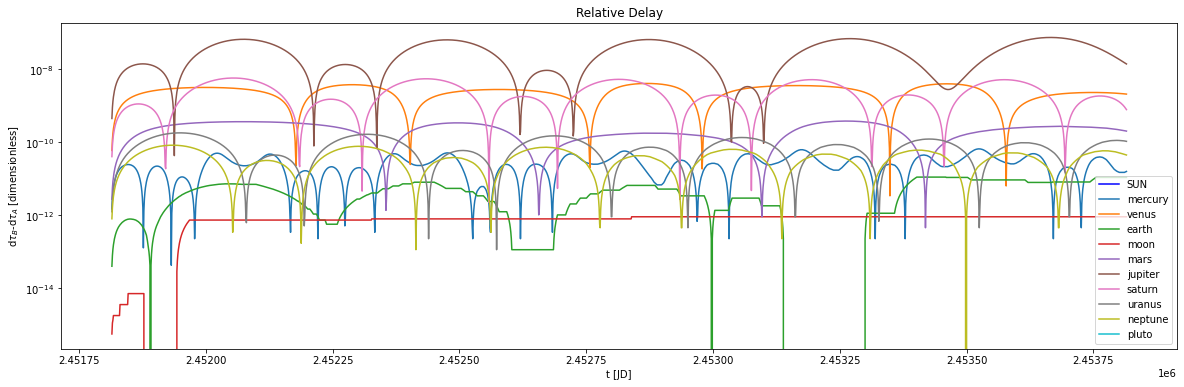

In [26]:
test_pos = [L4,L5]
test_clocks = ClockNetwork(test_pos,1.e1) 
meas_interval = 1 #in JD
delay_signal = test_clocks.calc_delay(0,1,meas_interval, time_array, solar_bodies, ss_mass, allpos)

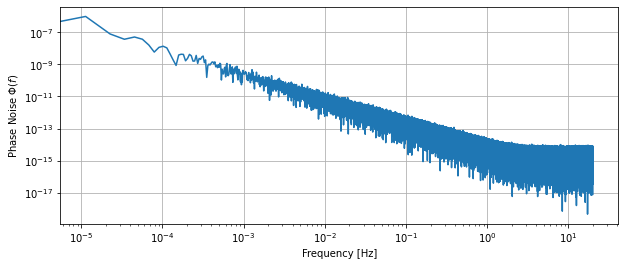

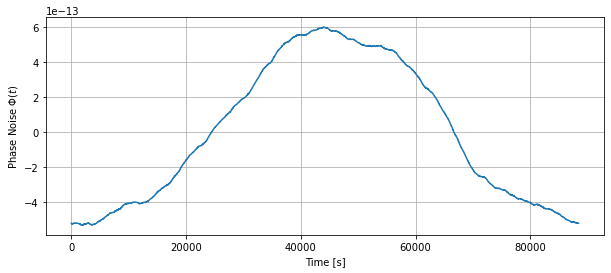

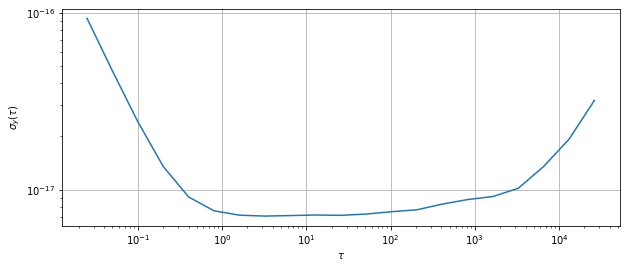

In [27]:
coloured_amp = np.array([1,0,1.e-4,10.,1.e-3])*1.e-3
noise = test_clocks.generate_noise(meas_interval, coloured_amp, 1., 1.e-12)

In [11]:
print('err=', noise[-2])

err= [4.94110213e-20 2.49275038e-20 1.28651279e-20 7.20784828e-21
 4.84176418e-21 4.03375897e-21 3.79776571e-21 3.73203044e-21
 3.71539975e-21 3.69727117e-21 3.70152513e-21 3.81671622e-21
 4.00085602e-21 4.22674324e-21 4.30643313e-21 4.43440454e-21
 4.70979675e-21 5.17247133e-21 7.13883031e-21 1.11601198e-20
 1.68825426e-20]


In [12]:
#Planet 9
sun_pos_i = get_body_barycentric_posvel('sun',initial_time)[0].get_xyz().to_value()*6.68459e-9
merc_pos_i = get_body_barycentric_posvel('mercury',initial_time)[0].get_xyz().to_value()*6.68459e-9
earth_pos_i = get_body_barycentric_posvel('earth',initial_time)[0].get_xyz().to_value()*6.68459e-9
solar_system_norm = np.cross(earth_pos_i-sun_pos_i, merc_pos_i-sun_pos_i)
print(sun_pos_i)
print(merc_pos_i)
print(earth_pos_i)

[-0.00538092 -0.00418844 -0.00162932]
[-0.00142101 -0.41283961 -0.2203258 ]
[0.99349976 0.0702726  0.03064978]


In [13]:
def PL9 (mass, distance, period, ti, t_total):
    """
    mass -kg
    distance, earth_r_i - AU
    period, t_total - JD
    ti - isot
    """
    
    #Angular velocity
    omega = (2*np.pi)/period #rad per JD
    
    #Take earth pos as unit vector
    u = get_body_barycentric_posvel('earth',ti)[0].get_xyz().to_value()*6.68459e-9
    
    #Set initial PL9 position
    pl9_ri = u*distance
    angles = np.linspace(0, t_total*omega, t_total)
    allt = ti + t_total * np.linspace(0., 1., t_total)

    pl9_pos = []
    earth_pos = []
    jup_pos = []
    for i in range(t_total):
        pl9_pos.append(list(Rotate(pl9_ri, solar_system_norm, angles[i])))
        earth_pos.append(get_body_barycentric_posvel('earth',allt[i])[0].get_xyz().to_value()*6.68459e-9)
        jup_pos.append(get_body_barycentric_posvel('jupiter',allt[i])[0].get_xyz().to_value()*6.68459e-9)
        
    plt.figure(figsize=(10,4))
    plt.plot(np.transpose(pl9_pos)[0], np.transpose(pl9_pos)[1], '--',label='pl9')
    plt.plot(np.transpose(earth_pos)[0], np.transpose(earth_pos)[1], '--',label='earth')
    plt.plot(np.transpose(jup_pos)[0], np.transpose(jup_pos)[1], '--',label='jupiter ')
    plt.legend()
    plt.show()
        
    return mass, pl9_pos

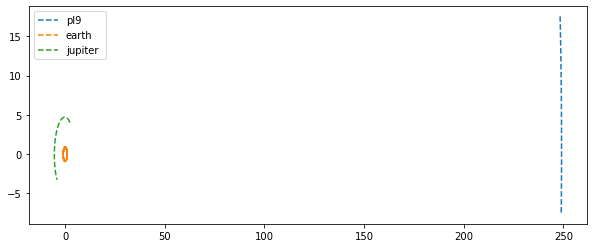

In [19]:
planet9 = PL9(2e31, 250, 300*365, initial_time, total_time)

In [15]:
len(allpos)
len(allpos[1])

2000

In [16]:
bodies_pl9 = np.append(np.array(solar_bodies),'PL9')
masses_pl9 = np.append(np.array(ss_mass),planet9[0])
allpos_pl9 = np.reshape(np.append(allpos,planet9[1]),(12,2000,3))

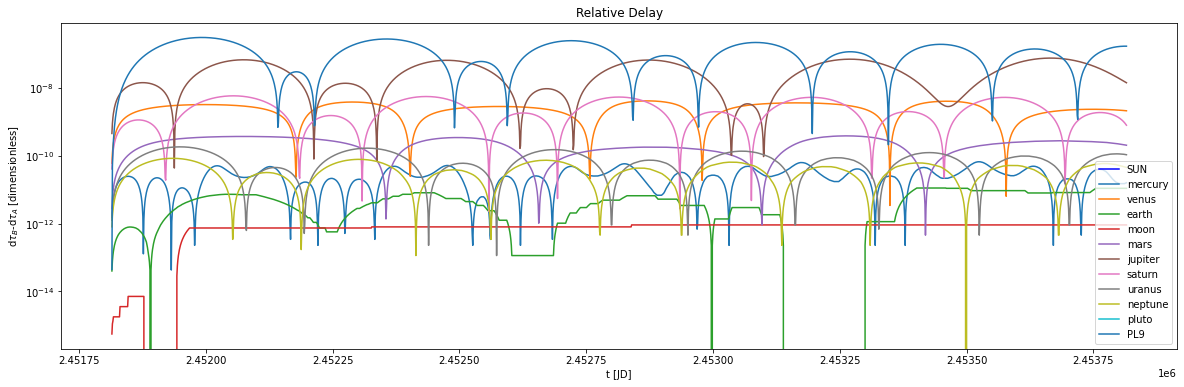

In [28]:
delay_signal_pl9 = test_clocks.calc_delay(0,1,meas_interval,time_array,bodies_pl9, masses_pl9, allpos_pl9)

In [38]:
tarray_jd = []
for i in time_array:
    tarray_jd.append(i.jd)

tarray_jd


[2451814.9659722224,
 2451815.9664724725,
 2451816.9669727227,
 2451817.967472973,
 2451818.9679732225,
 2451819.9684734726,
 2451820.968973723,
 2451821.969473973,
 2451822.969974223,
 2451823.970474473,
 2451824.9709747233,
 2451825.9714749735,
 2451826.9719752236,
 2451827.972475474,
 2451828.972975724,
 2451829.973475974,
 2451830.973976224,
 2451831.9744764743,
 2451832.9749767245,
 2451833.9754769746,
 2451834.9759772248,
 2451835.976477475,
 2451836.976977725,
 2451837.977477975,
 2451838.9779782253,
 2451839.9784784755,
 2451840.9789787256,
 2451841.9794789758,
 2451842.979979226,
 2451843.980479476,
 2451844.980979726,
 2451845.9814799763,
 2451846.981980226,
 2451847.982480476,
 2451848.9829807263,
 2451849.9834809764,
 2451850.9839812266,
 2451851.9844814767,
 2451852.984981727,
 2451853.985481977,
 2451854.985982227,
 2451855.9864824773,
 2451856.9869827274,
 2451857.9874829776,
 2451858.9879832277,
 2451859.988483478,
 2451860.988983728,
 2451861.989483978,
 2451862.989984